Use Gensim Library for the model classes.

1. Sentiment Classification using Pre-trained Word Embeddings (Transfer Learning)

Train a sentiment analysis model using GloVe or Word2Vec word embeddings with Keras.

i. Load the IMDb movie review dataset using keras.datasets.imdb.

ii. Preprocess the data: pad/truncate sequences to a fixed length.

iii. Download and load GloVe pre-trained word vectors (e.g., glove.6B.100d.txt).

iv. Create an embedding matrix using the GloVe vectors.

v. Use a Sequential model with:
   - Embedding layer initialized with the embedding matrix (set trainable=False)
   - Flatten or LSTM/GRU
   - Dense layers for classification

vi. Compile and train the model. Evaluate using accuracy.

Provide the Results based on Accuracy/Loss plot and evaluation metrics on test data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.initializers import Constant
from sklearn.metrics import classification_report
import os


In [2]:
# 1. Load IMDb dataset
vocab_size = 10000
maxlen = 200

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Show dataset shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# View a sample review (sequence of word indices)
print("Sample review (as word indices):", x_train[0])
print("Label (0 = negative, 1 = positive):", y_train[0])

x_train shape: (25000, 200), y_train shape: (25000,)
x_test shape: (25000, 200), y_test shape: (25000,)
Sample review (as word indices): [   5   25  100   43  838  112   50  670    2    9   35  480  284    5
  150    4  172  112  167    2  336  385   39    4  172 4536 1111   17
  546   38   13  447    4  192   50   16    6  147 2025   19   14   22
    4 1920 4613  469    4   22   71   87   12   16   43  530   38   76
   15   13 1247    4   22   17  515   17   12   16  626   18    2    5
   62  386   12    8  316    8  106    5    4 2223 5244   16  480   66
 3785   33    4  130   12   16   38  619    5   25  124   51   36  135
   48   25 1415   33    6   22   12  215   28   77   52    5   14  407
   16   82    2    8    4  107  117 5952   15  256    4    2    7 3766
    5  723   36   71   43  530  476   26  400  317   46    7    4    2
 1029   13  104   88    4  381   15  297   98   32 2071   56   26  141
    6  194 7486   18    4  226   22   21  134  476   26  480    5  144
   30 5535 

In [12]:
# 2. Pad/truncate sequences
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [20]:
import os
import zipfile
import requests
from tqdm import tqdm

#  Define URL and filenames
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = "glove.6B.zip"
glove_txt_path = "glove.6B.100d.txt"

#  Download GloVe zip if not already present
if not os.path.exists(glove_zip_path):
    print("Downloading GloVe embeddings...")
    response = requests.get(glove_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(glove_zip_path, 'wb') as f, tqdm(
        desc="glove.6B.zip", total=total_size, unit='B', unit_scale=True
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            f.write(data)
            bar.update(len(data))
else:
    print("GloVe zip already exists.")

#  Extract only glove.6B.100d.txt
if not os.path.exists(glove_txt_path):
    print("Extracting glove.6B.100d.txt...")
    with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extract("glove.6B.100d.txt")
else:
    print("GloVe 100d file already extracted.")


GloVe zip already exists.
GloVe 100d file already extracted.


In [13]:
# 3. Load GloVe embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coeffs

print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

Loaded 400000 word vectors from GloVe.


In [14]:
# 4. Map IMDb word index to GloVe embeddings
word_index = imdb.get_word_index()
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [22]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional


In [23]:
# 5. Build model
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=False))

model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Optional
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.build(input_shape=(None, maxlen))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,092,801 (4.17 MB)

 Trainable params: 92,801 (362.50 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [24]:
# 6. Train model
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 106s 650ms/step - accuracy: 0.5014 - loss: 0.6968 - val_accuracy: 0.5406 - val_loss: 0.6885
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 141s 643ms/step - accuracy: 0.5581 - loss: 0.6824 - val_accuracy: 0.5968 - val_loss: 0.6619
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 143s 651ms/step - accuracy: 0.6120 - loss: 0.6536 - val_accuracy: 0.6616 - val_loss: 0.6084
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 139s 634ms/step - accuracy: 0.6768 - loss: 0.6018 - val_accuracy: 0.6824 - val_loss: 0.5902
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 632ms/step - accuracy: 0.7050 - loss: 0.5627 - val_accuracy: 0.6938 - val_loss: 0.5708


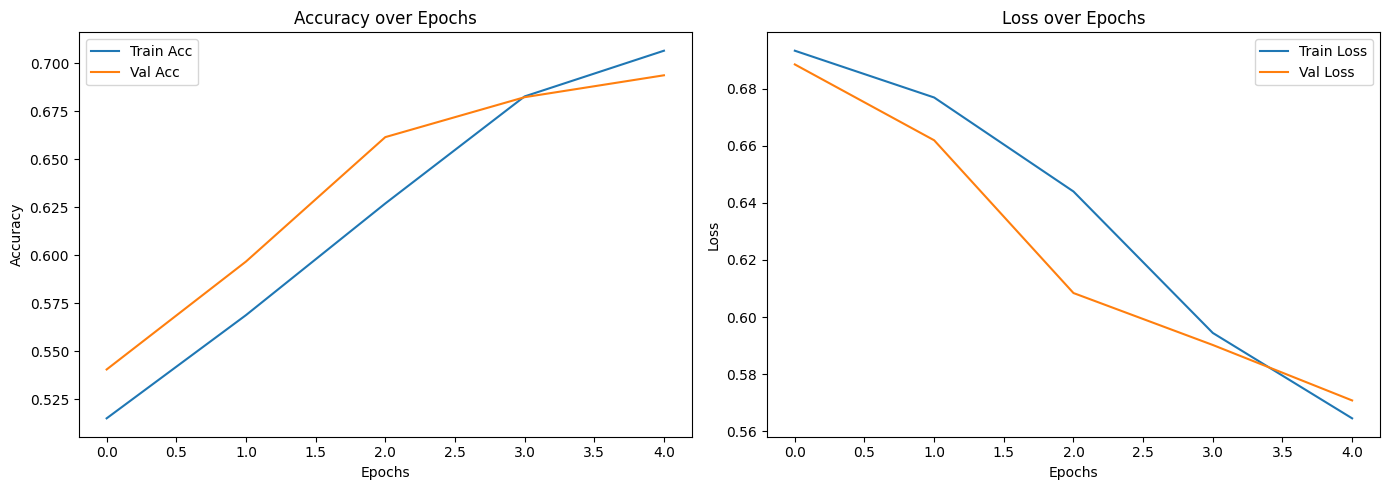

In [25]:
# 7. Plot accuracy and loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# 8. Evaluate
loss, accuracy = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# 9. Classification Report
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - accuracy: 0.6983 - loss: 0.5711

Test Accuracy: 0.7002
Test Loss: 0.5710
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step

Classification Report:

              precision    recall  f1-score   support

    Negative       0.68      0.76      0.72     12500
    Positive       0.73      0.64      0.68     12500

    accuracy                           0.70     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.70      0.70      0.70     25000

